# Plots for Poster SNE 24

`behav_fit2_copy` for bambi results
`beahv_fit ` for bauer results

In [2]:
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
plot_folder = op.join(bids_folder, 'plots_and_ims', 'poster_SNE24')

sns.set_context('talk')


### Bayesian Inference processes

at `behavior_magjudge/vis....`


# Magnitude Comparison Task

In [2]:
from numrisk.behavior_magjudge.utils import get_data

df= get_data(bids_folder,  include_var=['group'])
df = df.sort_index() # so first sub is Control, Control will be plotted first;) 

df['group'] = np.where(df['group'] == 0, 'Control', 'Dyscalculic')
df['n1'] = df['n1'].astype(int)
df.rename(columns={'n1':'Number range'}, inplace=True)




number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

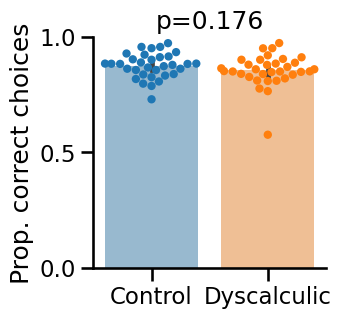

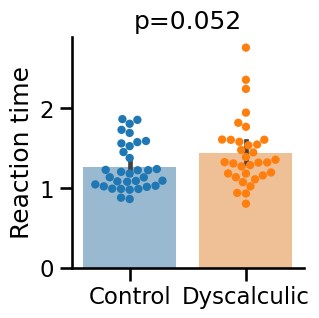

In [3]:
import pingouin as pg
df['correct_answer_n2'] = np.where((df['n2'] > df['n1']), True, False)
df['correct'] = np.where((df['correct_answer_n2'] == df['chose_n2']), True, False)

tmp = df.set_index('group', append=True)
tmp = tmp.groupby(['subject','group']).mean().reset_index()

for y_var, ylabel_name  in zip(['correct', 'rt'],['Prop. correct choices', 'Reaction time']):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    sns.barplot(ax=ax, data=tmp, x='group', hue='group', y=y_var, alpha=0.5)
    sns.swarmplot(ax=ax, data=tmp, x='group',  hue='group', y=y_var, size=6)

    an = pg.anova(data=tmp, dv=y_var, between='group')
    p_val = np.round(an['p-unc'][0],3)
    ax.set(title=f'p={p_val}',ylabel=ylabel_name,xlabel='') # ylim=(0.5,1.05),
    ax.set(ylim=[.5,1],yticks=[0,0.5,1]) if y_var == 'correct' else None
    sns.despine()

    plt.savefig(op.join(plot_folder, f'mag_raw_{y_var}.pdf'), bbox_inches='tight')

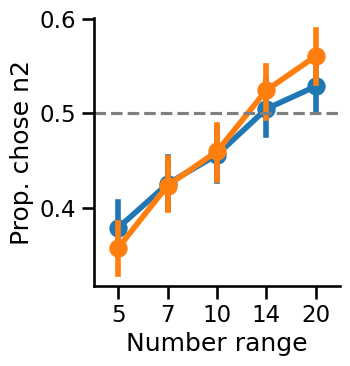

In [23]:
y_var = 'chose_n2'
x_var = 'Number range'
hue = 'group'

fig = sns.catplot(df.reset_index(), x=x_var, y=y_var, hue=hue,kind='point',height=4,aspect=1 ,errorbar='ci', legend=False) #  col='age',
fig.axes[0,0].set_ylabel('Prop. chose n2')
plt.axhline(y=0.5,color='grey', ls='--')
plt.savefig(op.join(plot_folder, 'mag_raw-chose-n2_number-range.pdf'), bbox_inches='tight')



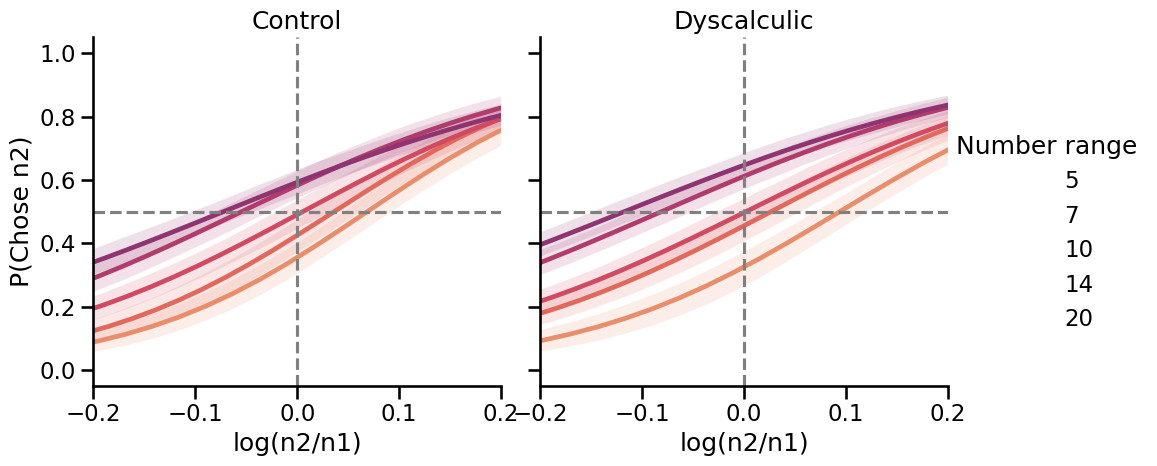

In [6]:
y_var = 'chose_n2'
x_var = 'log(n2/n1)'
hue = 'Number range'

palette = sns.color_palette('flare')#"dark:#5A9_r") #"blend:#7AB,#EDA") #,  n_colors=df[hue].nunique())

fig = sns.lmplot(df.reset_index(), x=x_var, y=y_var, hue= hue, col='group',ci=95,  
                 logistic=True,scatter_kws={'s': 0}, # show only the line and no 
                palette=palette)

fig.set_titles("{col_name}")

for ax in fig.axes.flat:
    ax.axvline(x=0,color='grey', ls='--')
    ax.axhline(y=0.5,color='grey', ls='--')
    ax.set_xlim(-.2,.2)

fig.axes[0,0].set_ylabel('P(Chose n2)')
plt.savefig(op.join(plot_folder, 'mag_logistic_number-range.pdf'), bbox_inches='tight')


In [3]:
# psychometric

import bambi # behav_fit2_copy
import arviz as az

model_label = 2
target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')
df['x'] = df['log(n2/n1)'] 

#model = bambi.Model('chose_n2 ~ x + x*n1*group + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))
for regressor, name in zip(['n1:group', 'x:group'], ['Number range', 'Slope']):
    temp = traces.posterior[regressor].to_dataframe()
    count_greater_zero = np.round(np.mean(temp[regressor] > 0),3)

    fig, axs = plt.subplots(1,1, figsize=(3,3), sharex=False)
    sns.kdeplot(temp[regressor], ax=axs,legend=False, fill=True, color='grey')
    axs.set(yticks=[],ylabel='Density',xlable='')
    axs.axvline(x=0, color='r', linestyle='--')
    axs.set_title(f'{name} x group \n p<{count_greater_zero}')
    sns.despine()
    plt.savefig(op.join(plot_folder, f'mag_psychometric_{regressor}.pdf'), bbox_inches='tight')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


NameError: name 'df' is not defined

In [21]:
# bauer model 
import arviz as az
from bauer.utils.bayes import softplus

target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')
traces =  az.from_netcdf(op.join(target_folder, f'model-3_trace.netcdf'))

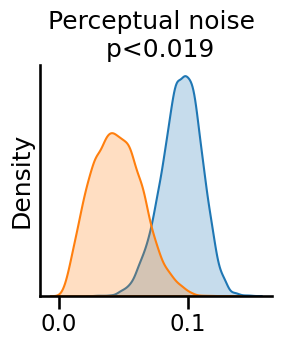

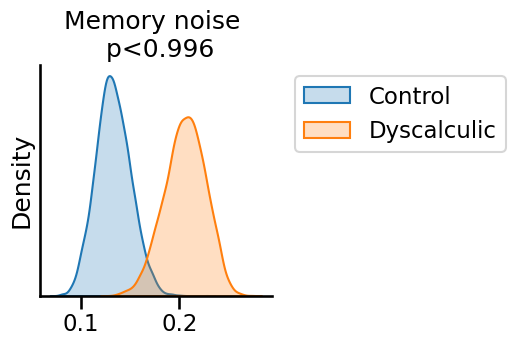

In [31]:
from bauer.utils.bayes import softplus

for noise in ['perceptual', 'memory']:
    tmp = traces.posterior[f'{noise}_noise_sd_mu'].to_dataframe()

    tmp = tmp.unstack(f'{noise}_noise_sd_regressors')
    control = tmp.xs('Intercept', 1, level=1)
    control = control.rename(columns={f'{noise}_noise_sd_mu':'Control'})
    control = softplus(control)
    dys = tmp.xs('Intercept', 1, level=1) + tmp.xs('group', 1, level=1)
    dys = dys.rename(columns={f'{noise}_noise_sd_mu':'Dyscalculic'})
    dys = softplus(dys)
    comb = pd.concat([control, dys], axis=1)
    comb['dif'] = comb['Dyscalculic'] - comb['Control']
    count_greater_zero = np.round(np.mean(comb['dif'] > 0),3)

    plt.figure(figsize=(3,3))
    sns.kdeplot(control, color='blue', fill=True, label='Control',legend=False)
    sns.kdeplot(dys['Dyscalculic'],  color=sns.color_palette()[1], fill=True, label='Dyscalculic')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') if noise== 'memory' else None
    plt.xlabel('')
    plt.yticks([])
    plt.title(f'{noise.capitalize()} noise \n p<{count_greater_zero}')
    sns.despine()
    plt.savefig(op.join(plot_folder, f'mag_bauer-3_{noise}_control-dys.pdf'), bbox_inches='tight')

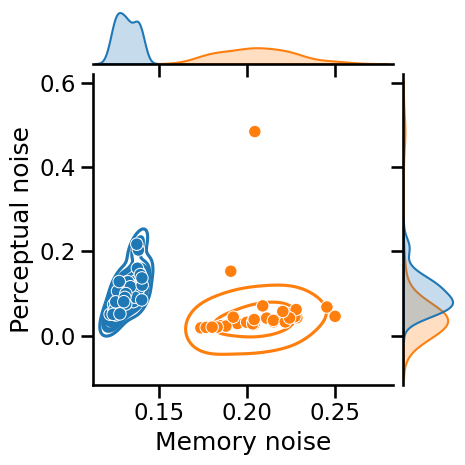

In [18]:
# subjectwise estimates (hierachically "biased")
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'
model_label =3 # 3 = memory_noise_sd & perceptual_noise_sd, 1 n1_evidence_sd & n2_evidence_sd, 
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-{model_label}_sds.csv')).set_index('subject')

x_var = 'memory_noise_sd' #'n1_evidence_sd' #
y_var = 'perceptual_noise_sd' # 'n2_evidence_sd' #
g = sns.jointplot(x=x_var, y=y_var, data=magjudge_bauer_params,  hue='group',height=5, legend=False)   # kind='kde',
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=10, legend=False)
g.set_axis_labels(xlabel='Memory noise', ylabel='Perceptual noise')
plt.savefig(op.join(plot_folder, f'mag_bauer-3_subwise-noise_jointplot.pdf'), bbox_inches='tight')

# Risky choice task

In [4]:
from numrisk.behavior_risk.utils import get_data
df= get_data(bids_folder)
df = df.sort_index() # so first sub is Control, Control will be plotted first;) 

df['group'] = np.where(df['group'] == 0, 'Control', 'Dyscalculic')
df['n_safe'] = df['n_safe'].astype(int)

df = df.xs('symbolic',0,'format')


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_68883/1447853714.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(['subject','group']).mean().reset_index()


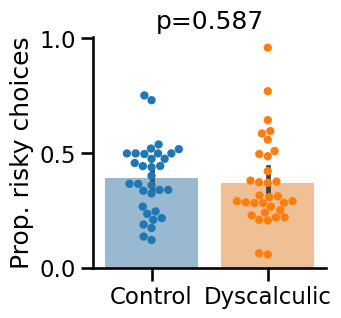

In [18]:
import pingouin as pg

tmp = df.set_index('group', append=True)
tmp = tmp.groupby(['subject','group']).mean().reset_index()

y_var = 'chose_risky'
fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.barplot(ax=ax, data=tmp, x='group', hue='group', y=y_var, alpha=0.5)
sns.swarmplot(ax=ax, data=tmp, x='group',  hue='group', y=y_var, size=6)

an = pg.anova(data=tmp, dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)
ax.set(title=f'p={p_val}',ylabel='Prop. risky choices',xlabel='',yticks=[0,0.5,1]) # ylim=(0.5,1.05),
sns.despine()

plt.savefig(op.join(plot_folder, 'risk_raw_chose-risky-symbolic.pdf'), bbox_inches='tight')

In [53]:
subList_remove = [40,46,50]
df = df[~df.index.get_level_values('subject').isin(subList_remove)]

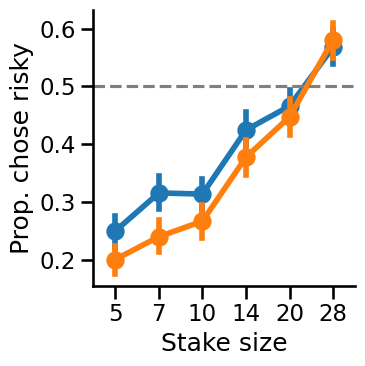

In [56]:
df.rename(columns={'n_safe':'Stake size'}, inplace=True)

x_var = 'Stake size'
hue = 'group'
y_var = 'chose_risky'

fig = sns.catplot(df.reset_index(), x=x_var, y=y_var, hue=hue,kind='point',height=4,aspect=1 ,errorbar='ci', legend=False) #  col='age',
fig.axes[0,0].set_ylabel('Prop. chose risky')
plt.axhline(y=0.5,color='grey', ls='--')
plt.savefig(op.join(plot_folder, 'risk_raw-chose-risky_stake-size.pdf'), bbox_inches='tight')



In [54]:
df['EVdif_natural'] = df['n_risky']*0.55 - df['n_safe']

Text(68.15077430555557, 0.5, 'P(Chose risky)')

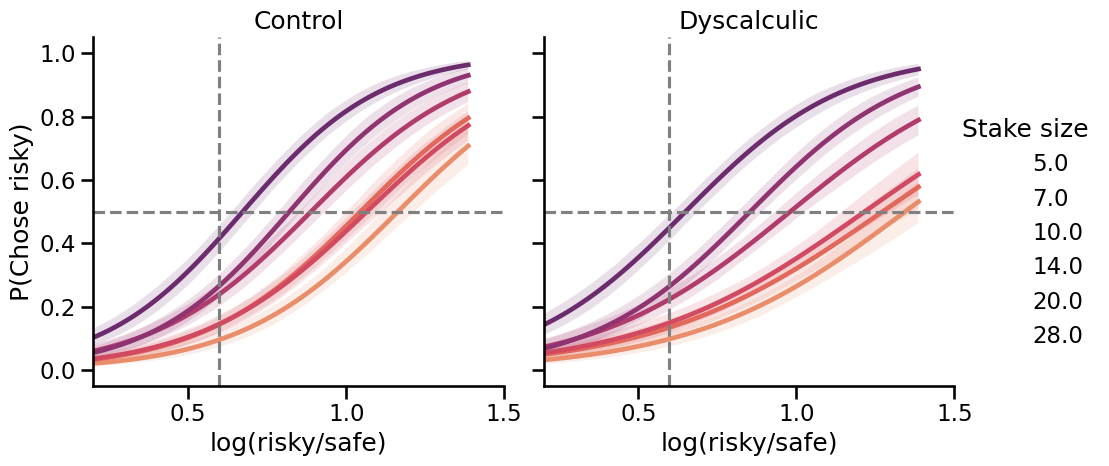

In [30]:
df.rename(columns={'n_safe':'Stake size'}, inplace=True)

x_var = 'log(risky/safe)' # bin(risky/safe)
y_var = 'chose_risky'

hue = 'Stake size'
palette = sns.color_palette('flare')#"dark:#5A9_r") #"blend:#7AB,#EDA") #,  n_colors=df[hue].nunique())

fig = sns.lmplot(df.reset_index(), x=x_var, y=y_var, hue= hue, col='group',ci=95,  
                 logistic=True,scatter_kws={'s': 0}, # show only the line and no 
                palette=palette)

fig.set_titles("{col_name}")

for ax in fig.axes.flat:
    ax.axvline(x=np.log(1/0.55),color='grey', ls='--')
    ax.axhline(y=0.5,color='grey', ls='--')
    ax.set_xlim(0.2,1.5)

fig.axes[0,0].set_ylabel('P(Chose risky)')
#plt.savefig(op.join(plot_folder, 'risk_logistic_stake-size.pdf'), bbox_inches='tight')
# remove 'scatter_kws={'s': 0}' to show the data points in the legend, save as _legend-dots.pdf

In [3]:
# bambi model
import arviz as az
import bambi 

model_label = '2rem1'
format = 'symbolic'
data = df#.xs(format, 0, level='format')
data['x'] = data['log(risky/safe)']
model = bambi.Model('chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=data.reset_index())
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


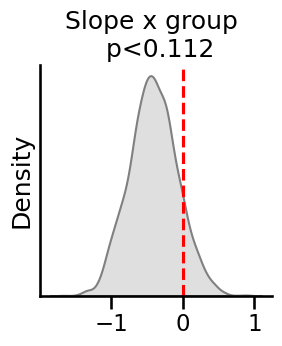

In [4]:
regressor = 'x:group'
temp = traces.posterior[regressor].to_dataframe()
count_greater_zero = np.round(np.mean(temp[regressor] > 0),3)

fig, axs = plt.subplots(1,1, figsize=(3,3), sharex=False)
sns.kdeplot(temp[regressor], ax=axs,legend=False, fill=True, color='grey')
axs.set(yticks=[],ylabel='Density', xlabel = '')
axs.axvline(x=0, color='r', linestyle='--')
axs.set_title(f'Slope x group \n p<{count_greater_zero}')
sns.despine()
plt.savefig(op.join(plot_folder, f'risk_psychometric_{regressor}.pdf'), bbox_inches='tight')

In [5]:
from numrisk.behavior_risk.utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, data, format=False, group_level = True)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)
rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


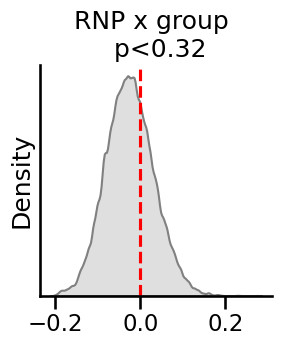

In [6]:
rnp_dif = rnp.xs('Dyscalculic',0,'group') - rnp.xs('Control',0,'group')

regressor = 'rnp'
temp = rnp_dif
count_greater_zero = np.round(np.mean(temp > 0),3)[0]

fig, axs = plt.subplots(1,1, figsize=(3,3), sharex=False)
sns.kdeplot(temp[regressor], ax=axs,legend=False, fill=True, color='grey')
axs.set(yticks=[],ylabel='Density', xlabel = '')
axs.axvline(x=0, color='r', linestyle='--')
axs.set_title(f'RNP x group \n p<{count_greater_zero}')
sns.despine()
plt.savefig(op.join(plot_folder, f'risk_psychometric_{regressor}.pdf'), bbox_inches='tight')


In [8]:
# stake-size:RNP:group effects
from itertools import product

n_chains = rnp.index.unique('chain').values
n_draws = rnp.index.unique('draw').values

index = pd.MultiIndex.from_product([n_chains, n_draws], names=['chain', 'draw'])



In [ ]:
# general stake-size:RNP effect

df_ss_rnp = pd.DataFrame(index=index, columns=['slope', 'intercept'])

for chain, draw in product(n_chains, n_draws):
    rnp_sample = rnp.xs(chain, level='chain').xs(draw, level='draw').reset_index('n_safe')

    tmp = rnp_sample.xs('Control',0,level='group')
    A1 = np.vstack([tmp['n_safe'], np.ones(len(tmp))]).T
    slope0, intercept0 = np.linalg.lstsq(A1, tmp['rnp'], rcond=None)[0]

    df_ss_rnp.loc[(chain, draw), 'slope'] = slope0
    df_ss_rnp.loc[(chain, draw), 'intercept'] = intercept0



mean=slope        0.008793
intercept    0.281454
dtype: float64, 95%CI=[nan nan]


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


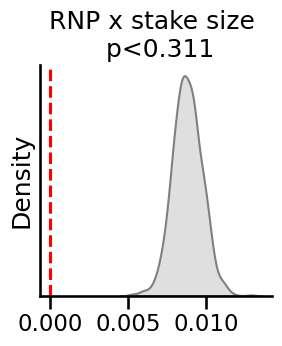

In [14]:
temp = df_ss_rnp#['slope']
count_greater_zero = np.round(np.mean(temp > 0),3)[0]
regressor = 'slope'
fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(temp[regressor], ax=ax,legend=False, fill=True, color='grey')
ax.axvline(x=0, color='r', linestyle='--')
ax.set(yticks=[],ylabel='Density',xlabel='')
ax.set_title(f'RNP x stake size \n p<{count_greater_zero}')
sns.despine()
print(f'mean={temp.mean()}, 95%CI={np.percentile(temp, [2.5, 97.5])}')
plt.savefig(op.join(plot_folder, f'risk_psychometric_StakeSize:RNP.pdf'), bbox_inches='tight')


In [ ]:

df_slope_diffs = pd.DataFrame(index=index, columns=['slope_difference', 'intercept_difference'])

for chain, draw in product(n_chains, n_draws):
    rnp_sample = rnp.xs(chain, level='chain').xs(draw, level='draw').reset_index('n_safe')

    tmp = rnp_sample.xs('Control',0,level='group')
    A1 = np.vstack([tmp['n_safe'], np.ones(len(tmp))]).T
    slope0, intercept0 = np.linalg.lstsq(A1, tmp['rnp'], rcond=None)[0]

    tmp = rnp_sample.xs('Dyscalculic',0,level='group')
    A1 = np.vstack([tmp['n_safe'], np.ones(len(tmp))]).T
    slope1, intercept1 = np.linalg.lstsq(A1, tmp['rnp'], rcond=None)[0]

    slope_differences = slope1 - slope0
    int_differences = intercept1 - intercept0

    df_slope_diffs.loc[(chain, draw), 'slope_difference'] = slope_differences
    df_slope_diffs.loc[(chain, draw), 'intercept_difference'] = int_differences

temp = df_slope_diffs['slope_difference']
count_greater_zero = np.round(np.mean(temp > 0),3)





mean=0.002795499846375044, 95%CI=[7.334788030388847e-05 0.0055607139879083]


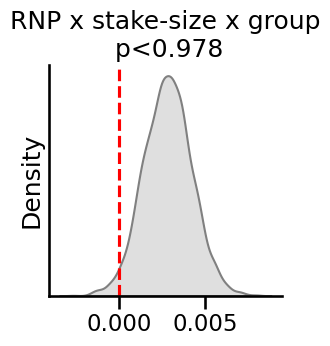

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(temp, fill=True, ax=ax, color='grey')
ax.axvline(x=0, color='r', linestyle='--')
ax.set(yticks=[],ylabel='Density',xlabel='')
ax.set_title(f'RNP x stake-size x group\n p<{count_greater_zero}')
sns.despine()
print(f'mean={temp.mean()}, 95%CI={np.percentile(temp, [2.5, 97.5])}')
plt.savefig(op.join(plot_folder, f'risk_psychometric_StakeSize:RNP:group.pdf'), bbox_inches='tight')

# Risk bauer model: classical NLC model (KLW) misfits!


In [7]:
# bauer: classical NLC model (KLW) misfits!
from numrisk.behavior_risk.utils import get_data

df = get_data(bids_folder)
format = 'symbolic'
df = df.xs(format,0, level='format')

from numrisk.behavior_risk.utils_02 import build_model
from numrisk.behavior_risk.utils_03 import plot_ppc

import arviz as az

model_label = '4' # prior_estimate = 'klw', RiskLapseRegressionModel
model_label = '8reg'# different evidences for safe (n1) & risky (n2) options & 2 prior mus but fix prior sd

model = build_model(model_label, df)
model.build_estimation_model()

number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [8]:
idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/model-{model_label}_format-{format}_trace.netcdf'))

ppc = model.ppc(idata=idata.sel(draw=slice(None, None, 10)), paradigm=df)
ppc['format'] = format
ppc = ppc.set_index(['format'], append=True)

df['format'] = format
df = df.set_index('format', append=True)


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Sampling: [ll_bernoulli]


In [10]:
#plot_type = 2 
#plot_ppc(df, ppc, level=level, plot_type=plot_type, var_name=var_name)

var_name = 'll_bernoulli'
level = 'group'

df['log(risky/safe)'] = df['bin(risky/safe)']
ppc = ppc.reset_index('log(risky/safe)')
ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

groupby = ['format', 'n_safe']
ppc = ppc.groupby(['subject', 'group']+groupby).mean()
groupby = ['group'] + groupby

from numrisk.behavior_risk.utils_03 import summarize_ppc, plot_prediction

ppc_summary = summarize_ppc(ppc, groupby=groupby)
p = df.groupby(groupby).mean()[['chose_risky']]
ppc_summary = ppc_summary.join(p).reset_index()
ppc_summary['Stake size'] = ppc_summary['n_safe'].astype(int)

ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

x = 'Stake size'
col_level = 'group'

ppc_summary['group'] = np.where(ppc_summary['group'] == 0, 'Control', 'Dyscalculic')


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_60439/2348270316.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject', 'group']+groupby).mean()
/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:133: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_60439/2348270316.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(gro

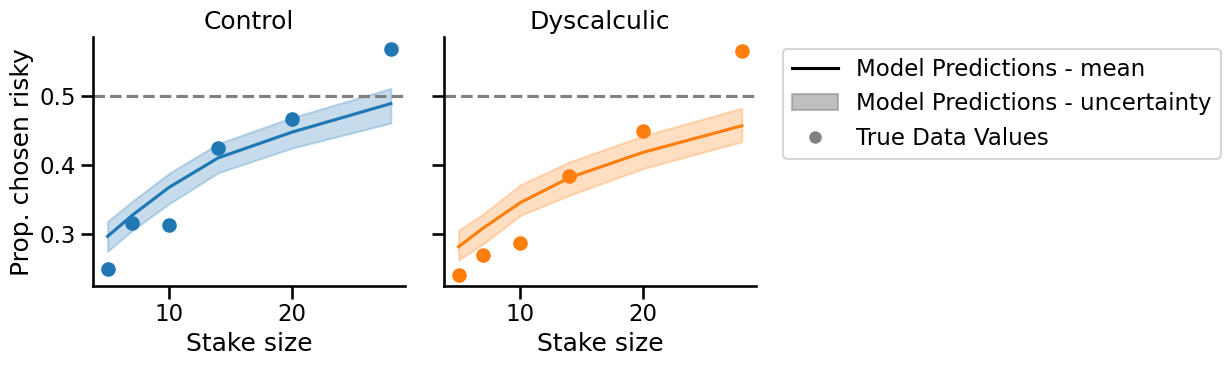

In [11]:
fac = sns.FacetGrid(ppc_summary,
                    col=col_level,
                    hue='group',
                    col_wrap=2 if level == 'subject' else None,
                    height=4,aspect=1)

fac.map_dataframe(plot_prediction, x=x)
fac.map(plt.scatter, x, 'Prop. chosen risky')
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='grey', ls='--'))
fac.set_titles("{col_name}")

# Create custom legend 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
handles = [
    Line2D([0], [0], color='k', linestyle='-', label='Model Predictions - mean'),
    Patch(facecolor='grey', edgecolor='grey', alpha=0.5, label='Model Predictions - uncertainty'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='True Data Values')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(op.join(plot_folder, f'risk_bauer-{model_label}.pdf'), bbox_inches='tight')

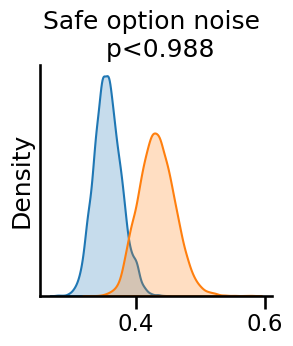

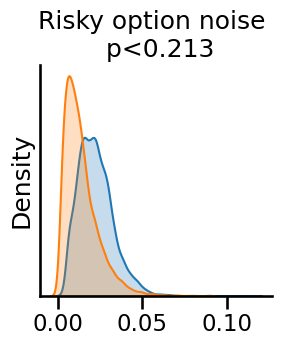

In [18]:
# group effect 

from bauer.utils.bayes import softplus

for noise, noise_name in zip(['n1', 'n2'], ['safe','risky']): # n1 = safe, n2 = risky
    tmp = idata.posterior[f'{noise}_evidence_sd_mu'].to_dataframe()

    tmp = tmp.unstack(f'{noise}_evidence_sd_regressors')
    control = tmp.xs('Intercept', 1, level=1)
    control = control.rename(columns={f'{noise}_evidence_sd_mu':'Control'})
    control = softplus(control)
    dys = tmp.xs('Intercept', 1, level=1) + tmp.xs('group', 1, level=1)
    dys = dys.rename(columns={f'{noise}_evidence_sd_mu':'Dyscalculic'})
    dys = softplus(dys)
    comb = pd.concat([control, dys], axis=1)
    comb['dif'] = comb['Dyscalculic'] - comb['Control']
    count_greater_zero = np.round(np.mean(comb['dif'] > 0),3)

    plt.figure(figsize=(3,3))
    sns.kdeplot(control, color='blue', fill=True, label='Control',legend=False)
    sns.kdeplot(dys['Dyscalculic'],  color=sns.color_palette()[1], fill=True, label='Dyscalculic')
    plt.xlabel('')
    plt.yticks([])
    plt.title(f'{noise_name.capitalize()} option noise \n p<{count_greater_zero}')
    sns.despine()
    plt.savefig(op.join(plot_folder, f'risk_bauer-{model_label}_{noise_name}_control-dys.pdf'), bbox_inches='tight')

In [12]:
from bauer.utils.bayes import softplus

safe = idata.posterior[f'n1_evidence_sd_mu'].to_dataframe()
safe = safe.unstack(f'n1_evidence_sd_regressors')
safe = safe.xs('Intercept', 1, level=1)
safe = safe.rename(columns={f'n1_evidence_sd_mu':'Safe'})
safe = softplus(safe)

risky = idata.posterior[f'n2_evidence_sd_mu'].to_dataframe()
risky = risky.unstack(f'n2_evidence_sd_regressors')
risky = risky.xs('Intercept', 1, level=1) 
risky = risky.rename(columns={f'n2_evidence_sd_mu':'Risky'})
risky = softplus(risky)

comb = pd.concat([safe, risky], axis=1)



In [ ]:
comb['dif'] = comb['Safe'] - comb['Risky']
count_greater_zero = np.round(np.mean(comb['dif'] > 0),3)

In [13]:
comb.head()

Safe     Risky       dif
chain draw                              
0     0     0.336868  0.024151  0.312717
      1     0.339075  0.025050  0.314026
      2     0.351033  0.020958  0.330075
      3     0.359952  0.021659  0.338293
      4     0.368890  0.040743  0.328147

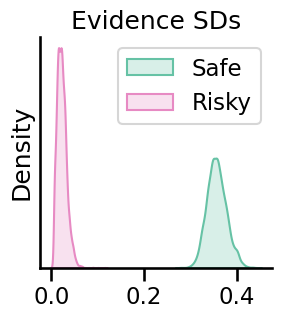

In [23]:
plt.figure(figsize=(3,3))
sns.kdeplot(safe['Safe'], fill=True,legend=True,color=sns.color_palette("Set2")[0],label = 'Safe')
sns.kdeplot(risky['Risky'], fill=True,legend=True, color=sns.color_palette("Set2")[3],label = 'Risky')
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.xlabel('')
plt.yticks([])
plt.title(f'Evidence SDs')
sns.despine()
plt.savefig(op.join(plot_folder, f'risk_bauer-{model_label}_SDs_safe-risky.pdf'), bbox_inches='tight')
